# Search using centroids and gene signatures

The goal of this tutorial is to demonstrate a more flexible method for cell search using centroids. Much of the early steps will be identical to the individual cell search tutorial and thus the explanations for those steps will be reduced for the sake of brevity. We will again use the [Adams et al. 2020](https://www.science.org/doi/10.1126/sciadv.aba1983?url_ver=Z39.88-2003&rfr_id=ori:rid:crossref.org&rfr_dat=cr_pub%20%200pubmed) healthy and IPF lung scRNA-seq data.

An important thing to note is that the cells input into the query are what determine the query results. The average of a scattered collection of cells will not bring meaningful results. There are some built-in quality controls stats you can use to evaluate the centroid quality and we will demonstrate them in this tutorial.

**There will be two analyses shown for querying cells:**

 1. Using a fibroblast signature, find cells of interest and perform cell search on their centroid.
 2. Using a non-specific signature, demonstrate how the QC stats indicate a poor centroid.

In [1]:
# Environment settings
import scanpy as sc
from matplotlib import pyplot as plt

plt.rcParams["figure.figsize"] = [6, 4]
sc.set_figure_params(dpi=100)


import warnings

warnings.filterwarnings("ignore")

## 1. Prepare for SCimilarity: Import and normalize data

In [2]:
from scimilarity.utils import lognorm_counts, align_dataset
from scimilarity import CellQuery

In [3]:
# If the models haven't been downloaded please uncomment and run the two command below
# !curl -L -o /models/query_model_v1.1.tar.gz \
#   https://zenodo.org/records/10685499/files/model_v1.1.tar.gz?download=1
# !tar -xzvf /models/query_model_v1.1.tar.gz

In [4]:
# Instantiate the CellQuery object
# Set model_path to the location of the uncompressed model
model_path = "/models/model_v1.1"
cq = CellQuery(model_path)

### Load scRNA-seq data

In [5]:
# To Download the demo data to the data/ directory uncomment and run the command below
# !curl -L -o "/data/GSE136831_subsample.h5ad" \
#   https://zenodo.org/records/13685881/files/GSE136831_subsample.h5ad?download=1

In [6]:
# Load and preprocess the tutorial data
# Set data_path to the location of the tutorial dataset
data_path = "/data/GSE136831_subsample.h5ad"
adams = sc.read(data_path)
adams = align_dataset(adams, cq.gene_order)
adams = lognorm_counts(adams)

## 2. Compute embeddings
Using the already trained models, SCimilarity can embed your new dataset. 

In [7]:
adams.obsm["X_scimilarity"] = cq.get_embeddings(adams.X)

In [8]:
sc.pp.neighbors(adams, use_rep="X_scimilarity")
sc.tl.umap(adams)

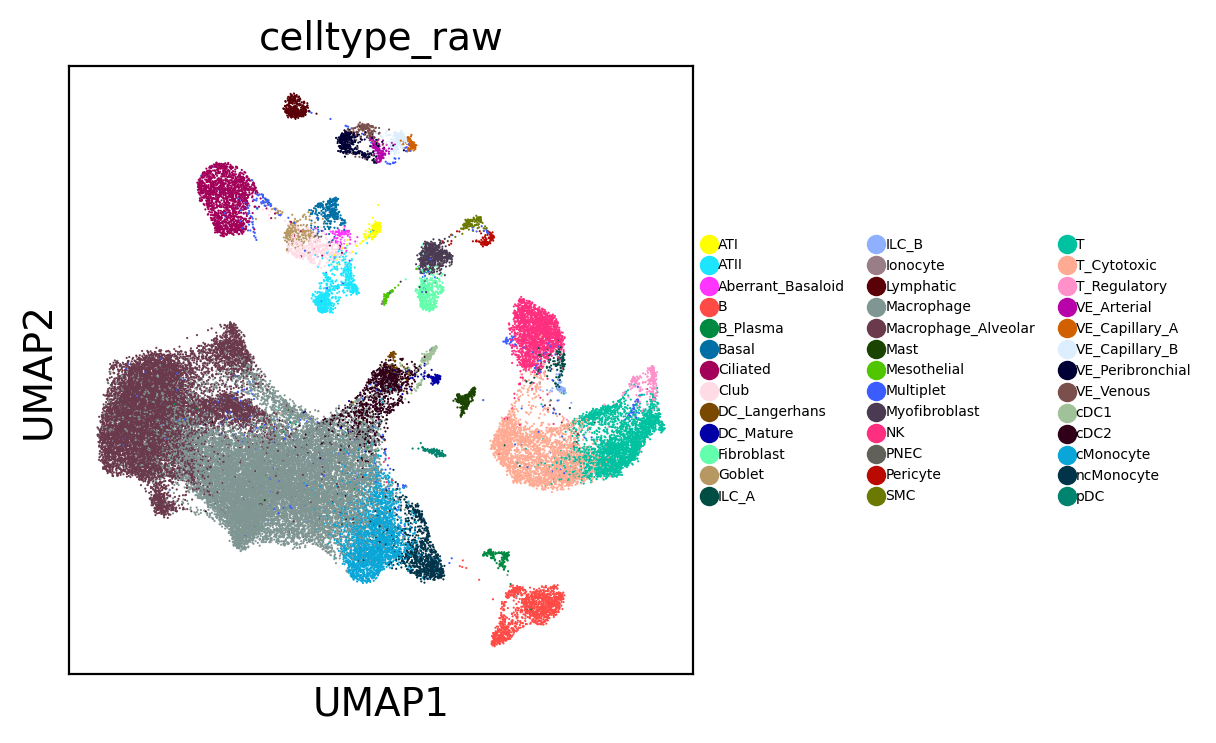

In [9]:
sc.pl.umap(adams, color="celltype_raw", legend_fontsize=5)

## 3. Identify query cell states

The more coherent and specific the query cell population is, the more interesting the results typically are. Cell states/subtypes are usually more interesting.

In this example, we do not need cell type information to identify query cells, rather we will use a gene signature for fibroblasts and a non-specific signature to illustrate the QC metrics we use to evaluate centroid quality.

In [10]:
# Score fibroblast signature
fibro_signature = [
    "ACTA2",
    "CDH11",
    "ELN",
    "LOXL1",
    "TNC",
    "ASPN",
    "COMP",
    "CTHRC1",
    "POSTN",
    "COL1A1",
    "COL3A1",
    "COL8A1",
]
sc.tl.score_genes(adams, fibro_signature, score_name="fibro_score")

# Score non-specific signature
nonspecific_signature = [
    "SOX8",
    "FABP4",
    "IRS1",
    "ADRA2A",
    "PPARGC1A",
    "SGK1",
    "APOC3",
    "NR4A1",
    "FOSB",
    "KLF7",
    "GFRA2",
    "RXRG",
    "THRB",
]
sc.tl.score_genes(adams, nonspecific_signature, score_name="nonspecific_score")

In [11]:
# Select fibroblast population
sig_query_threshold = adams.obs["fibro_score"].quantile(0.999)
cells_used_in_query = adams.obs["fibro_score"] >= sig_query_threshold
adams.obs["used_in_fibro_query"] = cells_used_in_query.astype(int)

# Select non-specific population
sig_query_threshold = adams.obs["nonspecific_score"].quantile(0.999)
cells_used_in_query = adams.obs["nonspecific_score"] >= sig_query_threshold
adams.obs["used_in_nonspecific_query"] = cells_used_in_query.astype(int)

As we are performing the search on a **centroid**, we very much want a tight collection of cells on which to calculate the centroid. Here we visualize the collection of cells to check coherence. These cells should ideally come from the same cluster and homogenous.

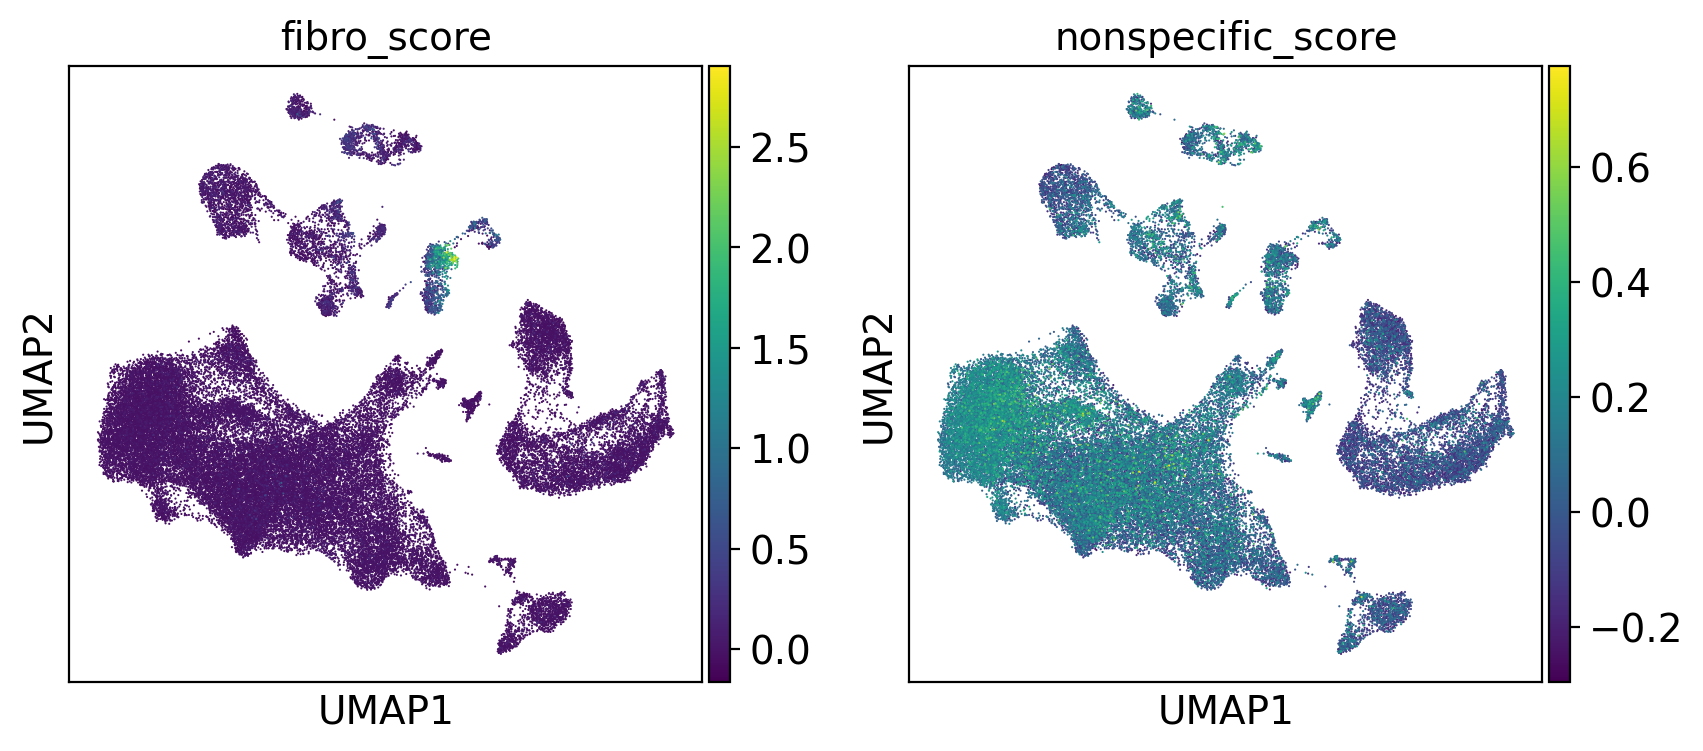

In [12]:
sc.pl.umap(adams, color=["fibro_score", "nonspecific_score"])

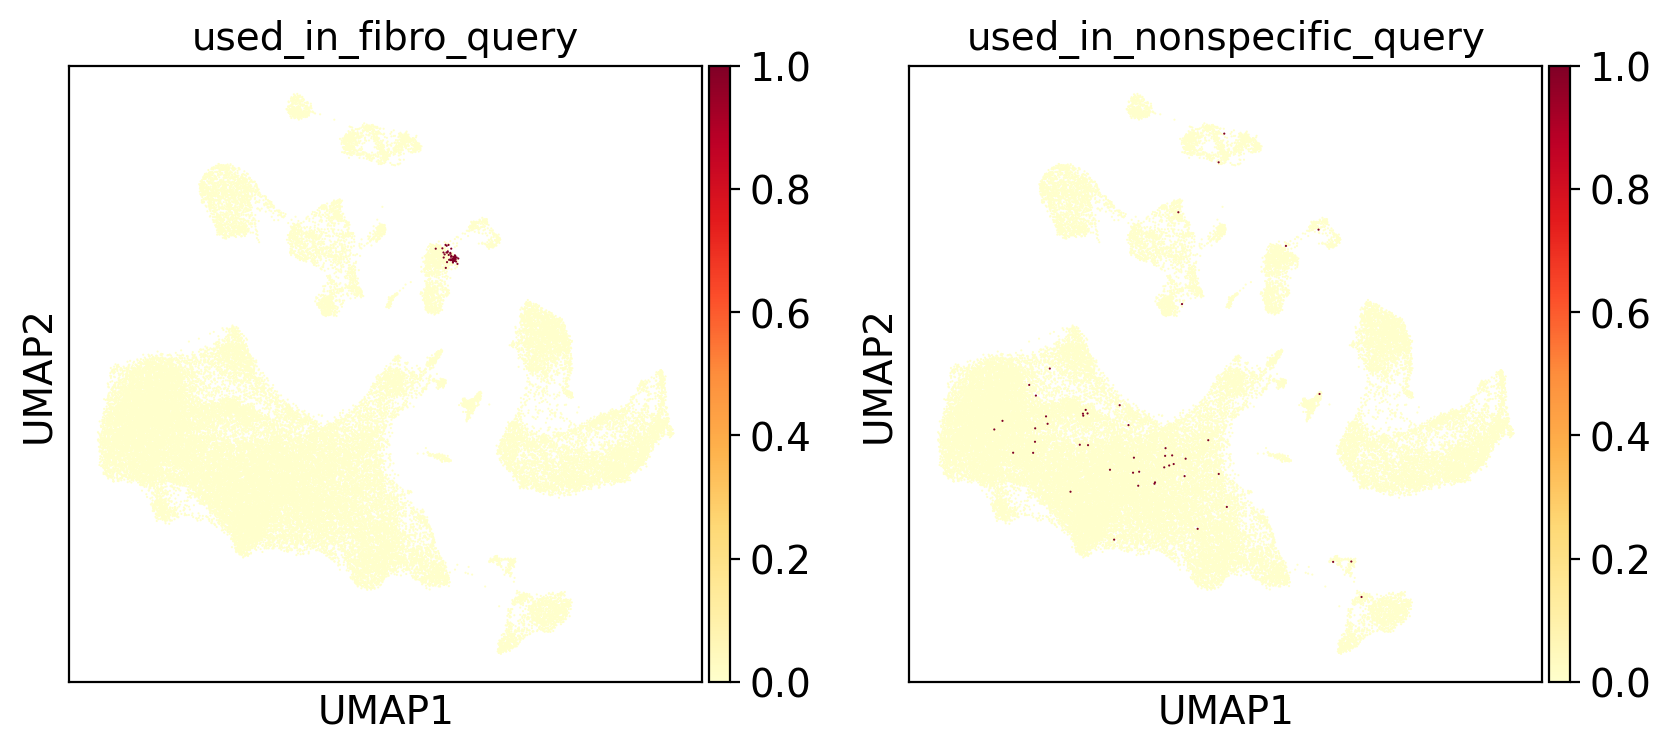

In [13]:
sc.pl.umap(
    adams, color=["used_in_fibro_query", "used_in_nonspecific_query"], cmap="YlOrRd"
)

## 4. Perform cell search on centroid
The centroid search method provides statistics with which you can evaluate the quality of the centroid and search results.

Quality control statistics:

  - `query_coherence`: consistency of query results between the centroid and cells that comprise the centroid.

In [14]:
# Fibroblast query
centroid_embedding, nn_idxs, nn_dists, fibro_results_metadata, qc_stats = (
    cq.search_centroid_kNN(adams, "used_in_fibro_query")
)
print(qc_stats)

{'query_coherence': 77.0}


In [15]:
# Non-specific query
centroid_embedding, nn_idxs, nn_dists, nonspecific_results_metadata, qc_stats = (
    cq.search_centroid_kNN(adams, "used_in_nonspecific_query")
)
print(qc_stats)

{'query_coherence': 3.7}


In [16]:
def calculate_disease_proportions(metadata):
    study_proportions = metadata.disease.value_counts()
    return 100 * study_proportions / study_proportions.sum()


def plot_proportions(df, title=None):
    ax = df.plot(
        kind="barh", xlabel="percent of cells", title=title, grid=False, figsize=(8, 5)
    )
    ax.tick_params(axis="y", labelsize=8)
    ax.set_xticklabels([f"{int(tick)}%" for tick in ax.get_xticks()])
    plt.tight_layout()

### Exclude self-referencing results
Naturally, searching for similar cells will highlight cells from the same study. To get a clearer view of the results, we often exclude self-referencing hits.

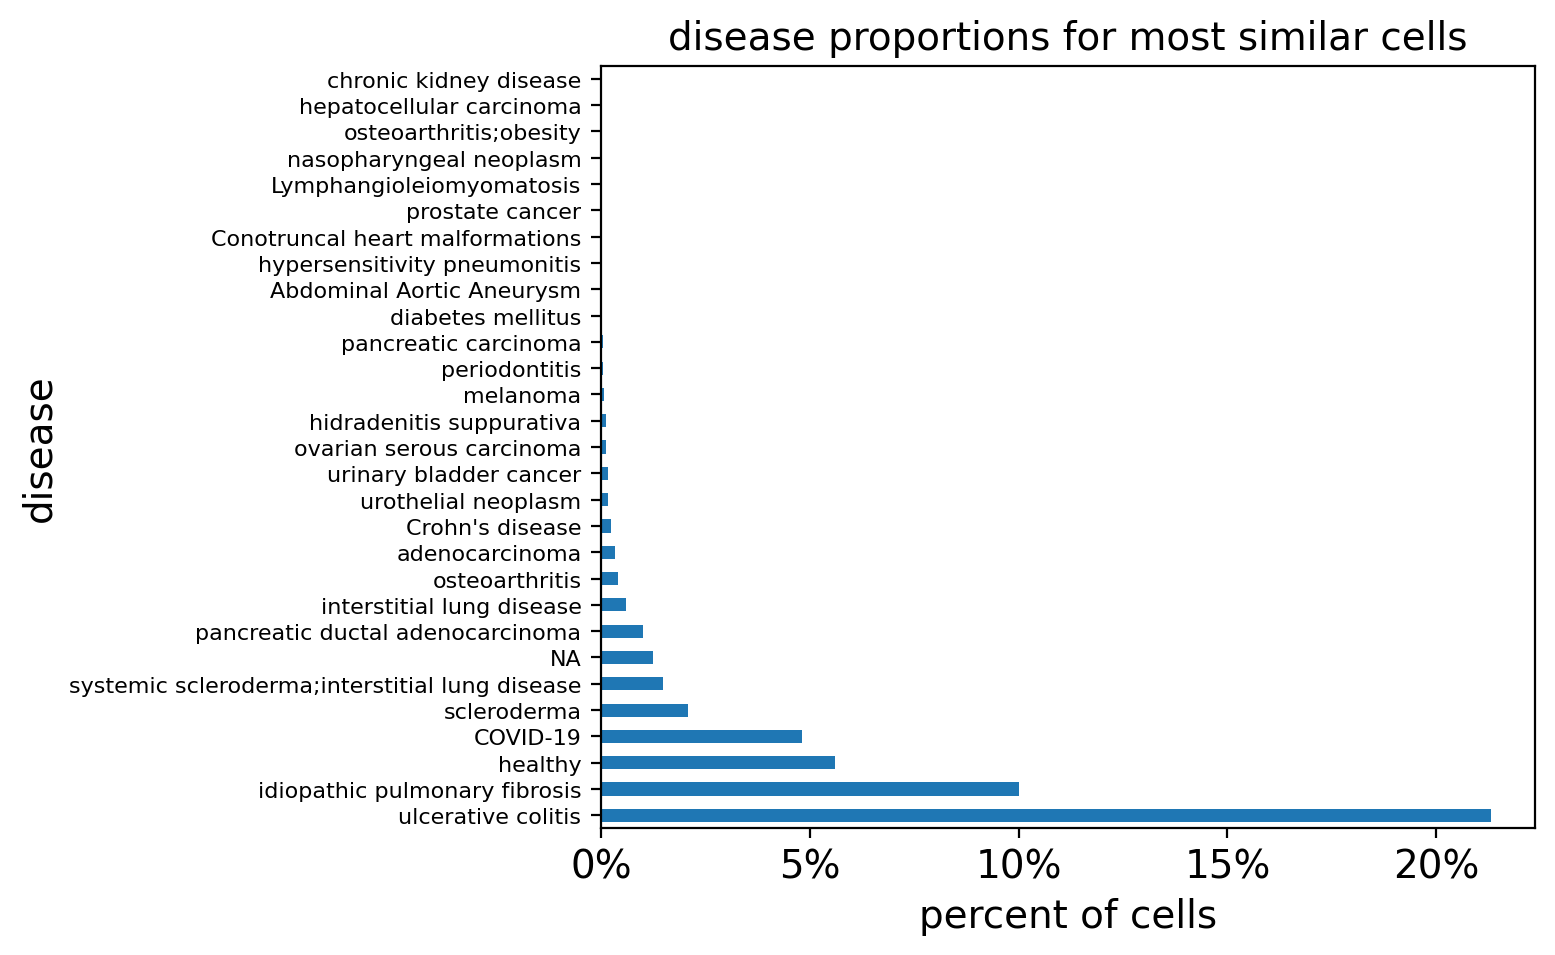

In [17]:
# Plot fibroblast query results
query_study = "DS000011735"
filtered_result_metadata = fibro_results_metadata[
    fibro_results_metadata.study != query_study
]
query_disease_frequencies = calculate_disease_proportions(filtered_result_metadata)
plot_proportions(
    query_disease_frequencies, title="disease proportions for most similar cells"
)

In [18]:
# Plot non-specific query results
query_study = "DS000011735"
filtered_result_metadata = nonspecific_results_metadata[
    nonspecific_results_metadata.study != query_study
]
display(filtered_result_metadata)

,index,study,sample,prediction,fm_signature_score,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,prediction_nn_dist,...,ESC-derived,xenograft,tissue,cell_line_cleaned,disease,FACS_sort,sex_cleaned,author_label,embedding_idx,query_nn_dist
2652,15863935,625f6bf4-2f33-4942-962e-35243d284837,D231,alveolar macrophage,0.297342,2957.0,7937.0,1003.0,12.637017,-2.384186e-07,...,NA,NA,lung,NA,healthy,NA,NA,alveolar macrophage,0,0.034953
3113,9098215,GSE128169,GSM3666105,macrophage,0.045086,3770.0,17756.0,1092.0,6.150034,1.689977e-02,...,False,False,lung,NA,interstitial lung disease,NA,NA,NA,0,0.035520
3265,16529736,a3ffde6c-7ad2-498a-903c-d58e732f7470,GTEX-13N11,alveolar macrophage,0.346360,1373.0,2684.0,328.0,12.220566,-1.192093e-07,...,NA,NA,lingula of left lung,NA,healthy,NA,NA,alveolar macrophage,0,0.035689
4157,15864492,625f6bf4-2f33-4942-962e-35243d284837,D231,alveolar macrophage,0.133228,2476.0,5157.0,402.0,7.795230,-2.384186e-07,...,NA,NA,lung,NA,healthy,NA,NA,alveolar macrophage,0,0.036569
5334,5862536,GSE158127,GSM4792476,macrophage,0.611310,1728.0,4587.0,630.0,13.734467,1.566196e-02,...,False,False,lung parenchyma,NA,COVID-19,CD31+,NA,NA,0,0.037533
6407,15864058,625f6bf4-2f33-4942-962e-35243d284837,D231,alveolar macrophage,0.053793,3258.0,9468.0,764.0,8.069286,1.192093e-07,...,NA,NA,lung,NA,healthy,NA,NA,alveolar macrophage,0,0.038293
6473,15864421,625f6bf4-2f33-4942-962e-35243d284837,D231,alveolar macrophage,0.431965,2457.0,5954.0,729.0,12.243870,0.000000e+00,...,NA,NA,lung,NA,healthy,NA,NA,alveolar macrophage,0,0.038344
7108,15867708,625f6bf4-2f33-4942-962e-35243d284837,D062,alveolar macrophage,0.339325,3580.0,9310.0,290.0,3.114930,0.000000e+00,...,NA,NA,lung,NA,healthy,NA,NA,alveolar macrophage,0,0.038765
7375,8752668,GSE161685,GSM4912703,alveolar macrophage,-0.227844,1636.0,2587.0,9.0,0.347893,7.890940e-03,...,False,False,lung,NA,healthy,NA,male,NA,0,0.038945
7995,16470667,a3ffde6c-7ad2-498a-903c-d58e732f7470,GTEX-15CHR,alveolar macrophage,0.555876,2978.0,6683.0,1056.0,15.801287,-3.576279e-07,...,NA,NA,prostate gland,NA,healthy,NA,NA,alveolar macrophage,0,0.039315


The results for the non-specific signature are empty after filtering out the query study because the centroid constructed is poor and could only match cells from the query study.

## Conclusion
This notebook outlines the basics of how to take a dataset, construct a centroid from a gene signature, and perform a cell search across our precomputed reference of 23.4M cells and summarize the results. You can use this as a template to expore cell states in other datasets you are interested in. 

Keep in mind that the datasets that you analyze with SCimilarity should fit the following criteria:
  - Data generated from the 10x Genomics Chromium platform (models are trained using this data only).
  - Human scRNA-seq data.
  - Counts normalized with SCimilarity functions or using the same process. Different normalizations will have poor results.

## Next: Advanced cell search using cluster centroids
This notebook demonstrated SCimilarity cell search on centroids and described the QC metrics that can be used to evaluate the quality of a centroid. Another common method for grouping cells is from clusters or cell type labels. Our QC metrics can also be applied to cluster centroids to evaluate the quality of those centroids.

Check out the next tutorial to learn how to search cell cluster centroids using SCimilarity!